In [26]:
import pykrige #biblioteca de geoestadística
import pykrige.kriging_tools as kt #herramientas para exportar e importar archivos .asc con biblioteca PyKrige
from pykrige.ok import OrdinaryKriging #Kriging Ordinario con PyKrige
import pandas as pd #biblioteca de manipulación y análisis de datos
import numpy as np #biblioteca de funciones matemáticas
import matplotlib.pyplot as plt #biblioteca de generación de gráficos

import geopandas as gpd
import matplotlib.style
import matplotlib as mpl
from shapely.geometry import MultiPoint

In [27]:
mpl.style.use('seaborn-whitegrid')
shapefile = gpd.read_file("narino/narino_3857.shp")
print(shapefile['geometry'])

0    MULTIPOLYGON (((-8789647.510 178242.695, -8789...
Name: geometry, dtype: geometry


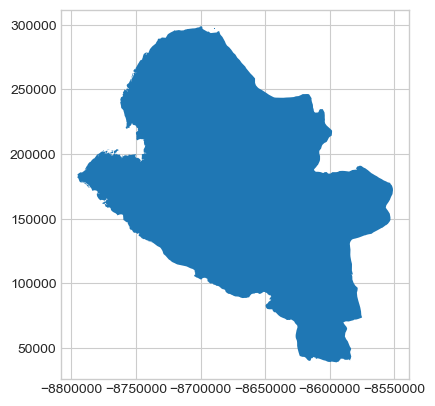

In [28]:

shapefile.plot()

In [29]:
from shapely.geometry import MultiPolygon

def points_from_polygons(polygons):
    points = []
    for mpoly in polygons:
        if isinstance(mpoly, MultiPolygon):
            polys = list(mpoly)
            print("YES")
        else:
            polys = [mpoly]
        for polygon in polys:
            for point in polygon.exterior.coords:
                points.append(point)
                
            for interior in polygon.interiors:
                for point in interior.coords:
                    points.append(point)
                
    return points

In [30]:
points = points_from_polygons(shapefile['geometry'])
#points = path_from_polygons(shapefile['geometry'])

#x = [point[0] for point in points]
#y = [point[1] for point in points]

YES


In [31]:
shp=shapefile['geometry']


In [32]:
import pandas as pd
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV
from KSVM import KSVC, KSVR

from sklearn.model_selection import train_test_split,KFold, cross_val_score,ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
import numpy as np
from time import time
from multiprocessing.pool import Pool
from sklearn.metrics import mean_absolute_error,mean_squared_error,median_absolute_error
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from matplotlib.colors import LinearSegmentedColormap

In [33]:
dff=pd.read_csv('landsat_model.csv')        
nr=dff.shape[1]
Xl=dff.iloc[:,0:nr-1]
yl=dff.iloc[:,nr-1:nr]    
yl=yl.values.ravel()
print(Xl.shape, yl.shape)
dff.head()

(434, 9) (434,)


,latitude,longitude,band1,band2,band3,band4,band5,band6,band7,value
0,-8789850.0,184950.0,0.105113,0.082716,0.052756,0.315520,0.132641,296.178607,0.044586,203.4
1,-8784900.0,174600.0,0.104840,0.085732,0.053527,0.271463,0.090247,295.969710,0.027292,198.3
2,-8775000.0,164700.0,0.103468,0.079147,0.048932,0.248619,0.078593,296.842689,0.022098,203.1
3,-8775000.0,169650.0,0.108849,0.090665,0.055715,0.338889,0.128227,296.123927,0.039798,199.1
4,-8775000.0,174600.0,0.096526,0.071028,0.042247,0.194788,0.054468,294.407491,0.017712,196.3


In [34]:
def normalizerTransform(x,nm):       
    if(nm=="Min_Max"):#mix-max
        scaler=MinMaxScaler()
        scaler.fit(x)
        return scaler.transform(x)
    if(nm=="Normalizer"):#normalizer
        scaler=Normalizer()
        scaler.fit(x)
        return scaler.transform(x)
    
    if(nm=="Standard"):#standard
        scaler=StandardScaler()
        scaler.fit(x)
        return scaler.transform(x)    
    return x

In [61]:
Xnl=normalizerTransform(Xl,'Standard')
#Xnl=normalizerTransform(Xl,'Min_Max')
#kernel= 'rquadratic', coef0= 0.1, C= 100.0
#C=10000.,gamma=100.,kernel='triangle'
clfl=KSVR(kernel= 'triangle', gamma= 100.0, C= 1000.0)
#clfl=KSVR(kernel= 'rquadratic', coef0= 0.1, C= 1000.0)
Xfl, Xtl, yfl, ytl = train_test_split(Xnl, yl, test_size=1/3,random_state=0)
clfl.fit(Xfl,yfl)
stl=clfl.score(Xtl,ytl)
sfl=clfl.score(Xfl,yfl)
sal=clfl.score(Xnl,yl)
print(stl,sfl,sal)

0.9269274927131531 0.9928749221752412 0.9683839382641498


In [36]:


def drawPrediction(yp,yt,nfile='.',title=''):
    #Realizamos la representación gráfica de los datos obtenidos
    fig, ax = plt.subplots()    
    fig.set_size_inches(15,5)    
    #Graficamos un cruce entre los datos obtenidos vs los datos esperados
    plt.subplot(1,2,1)
    
    plt.plot(yt, yp, marker='o',color='royalblue' ,linestyle='none',markeredgecolor='black')
    plt.plot(yt, yt,color='red',linewidth=1.5)
    plt.title("Cross data")
    plt.xlabel("predicted")
    plt.ylabel("true")
    plt.grid(True)
    #Graficamos una comparación entre los datos obtenidos y los deseados
    num_values = range(0,yt.shape[0],10)
    plt.subplot(1,2,2)
    plt.title("Trace")
    t=num_values
    plt.ylabel("cnt Radiación")
    plt.plot(t,yp[num_values],'r', label='cnt predicted')
    plt.plot(t,yt[num_values],'g', label='cnt true')
    plt.legend(loc='best')
    plt.xlabel("Data number")
    plt.grid(True)
    plt.show()


In [63]:
x=np.array(dff['latitude'].tolist())
y=np.array(dff['longitude'].tolist())
z=clfl.predict(Xnl)

#z=np.array(dff['value'].tolist())

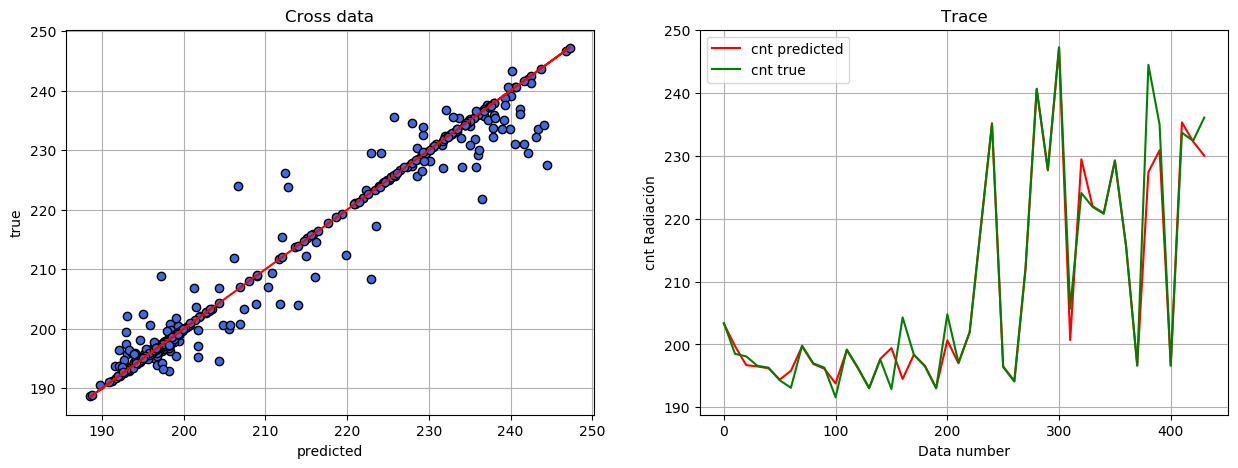

In [64]:
drawPrediction(z,yl)

In [39]:
def show_map2(x,y,z, clf, distance, resolution=450):

    np.random.seed(19680801)
    npts = x.shape[0]
    ngridx = resolution
    ngridy = resolution
  
    x_min=x.min()
    x_max=x.max()
    y_min=y.min()
    y_max=y.max()
    xi = np.linspace(x_min,x_max, ngridx)
    yi = np.linspace(y_min,y_max, ngridy)   
   
    Xi, Yi = np.meshgrid(xi, yi)
    Xi=Xi.ravel()
    Yi=Yi.ravel()
    
    xt=np.array([x,y]).T    
    
    Xt=np.array([Xi,Yi]).T
    print('xt',xt.shape)
    
    v_id=[]
    for i,xti in enumerate(Xt):
        dis=np.sum((xt-xti)**2, axis=1)**0.5
        
        if(dis.min()<=distance):
            v_id.append(i)
            


    print('Eliminados', len(v_id))

    print('antes')
    print(Xt.shape,Xi.shape, Yi.shape)
    Xt=Xt[v_id]
    Xi=Xi[v_id]
    Yi=Yi[v_id]


    print('despues')
    
    zi=clf.predict(Xt) 
    print(Xt.shape,Xi.shape, Yi.shape,zi.shape)
    
    
    colors = [(0, 0, 1), (0, 0.7, 0),(0, 1, 0),(0.9,1,0),(1,0.7,0),(1, 0.5, 0),(1, 0, 0) ]
    cmap_name = 'my_list'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
    
    marker_size = 10    
        
            
    plt.scatter(Xi, Yi, marker_size, zi, cmap=cm)
    
    plt.title("Radiación solar")
    cbar = plt.colorbar()
    cbar.set_label("W/m^2", labelpad=+1)
    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def show_mapP(points,clf):
    np.random.seed(19680801)       
    zi=clf.predict(points) 
    Xi = [point[0] for point in points]
    Yi = [point[1] for point in points]
    
    colors = [(0, 0, 1), (0, 0.7, 0),(0, 1, 0),(0.9,1,0),(1,0.7,0),(1, 0.5, 0),(1, 0, 0) ]
    cmap_name = 'my_list'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
    
    marker_size = 1
    
        
            
    plt.scatter(Xi, Yi, marker_size, zi, cmap=cm)
    
    plt.title("Radiación solar")
    cbar = plt.colorbar()
    cbar.set_label("W/m^2", labelpad=+1)
    plt.axis('equal')
    plt.xlabel("Este [X]")
    plt.ylabel("Norte [Y]")
    plt.show()
    
def show_mapC(x,y,z):
    np.random.seed(19680801)       
    zi=z 
    Xi = x
    Yi = y
    
    colors = [(0, 0, 1), (0, 0.7, 0),(0, 1, 0),(0.9,1,0),(1,0.7,0),(1, 0.5, 0),(1, 0, 0) ]
    cmap_name = 'my_list'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
    
    marker_size = 1
    
        
            
    plt.scatter(Xi, Yi, marker_size, zi, cmap=cm)
    
    plt.title("Radiación solar")
    cbar = plt.colorbar()
    cbar.set_label("W/m^2", labelpad=+1)
    plt.axis('equal')
    plt.xlabel("Este [X]")
    plt.ylabel("Norte [Y]")
    plt.show()

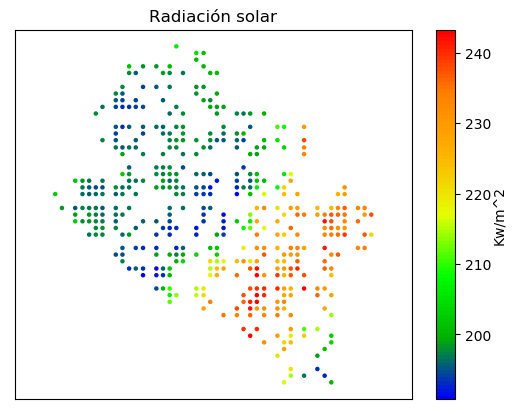

In [40]:
mpl.style.use('default')
colors = [(0, 0, 1), (0, 0.7, 0),(0, 1, 0),(0.9,1,0),(1,0.7,0),(1, 0.5, 0),(1, 0, 0) ]
cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
marker_size = 5
plt.scatter(x, y, marker_size, z, cmap=cm) 
plt.axis('equal')
plt.title("Radiación solar")
cbar = plt.colorbar()
cbar.set_label("Kw/m^2", labelpad=+1)
plt.xticks([])
plt.yticks([])
plt.show()

In [41]:
def getGridPoints(x,y,resolution,polygons):    
    x_min,x_max, y_min, y_max=x.min(),x.max(),y.min(), y.max()
    xi = np.linspace(x_min,x_max, resolution)
    yi = np.linspace(y_min,y_max, resolution)   
   
    Xi, Yi = np.meshgrid(xi, yi)
    Xi=Xi.ravel()
    Yi=Yi.ravel()
    mpoints=np.array([Xi.ravel(),Yi.ravel()]).T
    points = MultiPoint(mpoints)  
    index=[]
    for point in points:
        for polygon in polygons:
            if polygon.contains(point):
                index.append(True)
            else:
                index.append(False)
    
    return mpoints[index]
    


In [18]:
#points=getGridPoints(x,y,450,shp)
#dexport=pd.DataFrame({'lat':points[:,0],'lon':points[:,1]})
#dexport.to_csv('gridNarinio.csv')

In [42]:
dfnar=pd.read_csv('gridNarinio.csv')
dfnar.head()
mpoints=np.array([dfnar["lat"].tolist(),dfnar["lon"]]).T
mpoints

array([[-8623484.29844098,    45000.        ],
       [-8622961.13585746,    45000.        ],
       [-8622437.97327394,    45000.        ],
       ...,
       [-8686786.97104677,   294750.        ],
       [-8686263.80846325,   294750.        ],
       [-8685740.64587973,   294750.        ]])

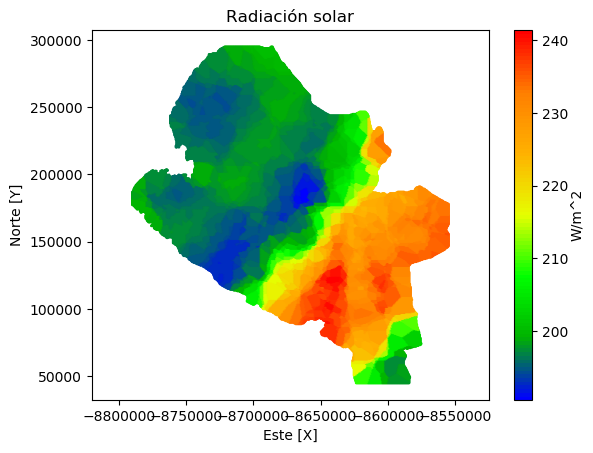

In [65]:
mpl.style.use('default')
from sklearn.neighbors import KNeighborsRegressor
xt=dff.iloc[:,0:2]
yt=z

x_f, x_t, y_f,y_t=train_test_split(xt, yt, test_size=0.2)
neigh = KNeighborsRegressor(n_neighbors=4)
neigh.fit(x_f, y_f)
show_mapP(mpoints,neigh)

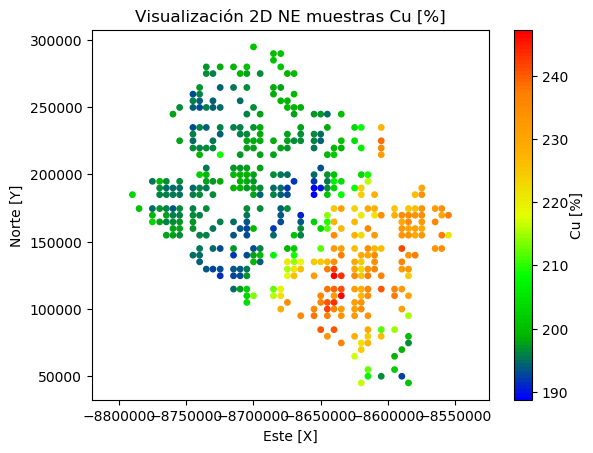

In [66]:
#variables convertidas a ndarray: Matriz Numpy

x = x
y = y
cu = z

#ploteo:
marker_size = 15
plt.scatter(x, y, marker_size, cu, cmap=cm) #el estilo gist_rainbow es algo mas convencional.
plt.xlabel("Este [X]")
plt.ylabel("Norte [Y]")
plt.title("Visualización 2D NE muestras Cu [%]")
cbar = plt.colorbar()
cbar.set_label("Cu [%]", labelpad=+1)
plt.axis('equal')
#plt.axis('equal')
plt.show()


In [67]:
print("std2: ",round(cu.var(), 2),"mean:",round(cu.mean(), 2),
      "max:",round(cu.max(), 2),"min:",round(cu.min(), 2)) #Referencia para el variograma.


std2:  279.07 mean: 209.52 max: 247.2 min: 188.76


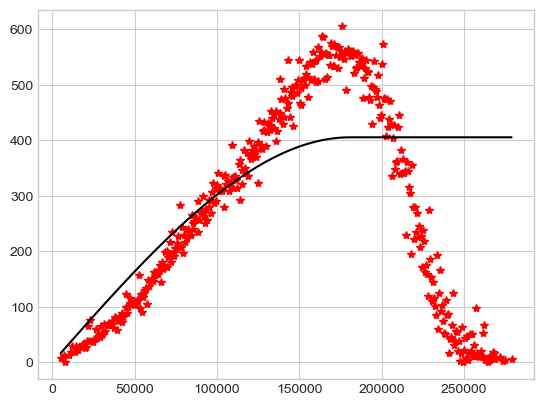

In [68]:
mpl.style.use('seaborn-whitegrid')
OK = OrdinaryKriging(x,y,cu, variogram_model='spherical', nlags=450, 
                    enable_plotting=True, 
                    coordinates_type='euclidean')

#Ajuste del variograma experimental con un modelo esférico, 20 pasos, una meseta de 0.22 (lo cual es la varianza de los datos)
#, alcance de 175 metros y sin efecto pepita.

In [69]:
x_min=x.min()
x_max=x.max()
y_min=y.min()
y_max=y.max()
grid_x = np.linspace(x_min, x_max, num=450, endpoint=False) #Se crean 46 celdas de 10 metros desde min() - max() del eje X.
grid_y = np.linspace(y_min, y_max, num=450, endpoint=False) #Se crean 41 celdas de 10 metros desde min() - max() del eje Y.

In [70]:

Xi =np.array([point[0] for point in mpoints])
Yi =np.array([point[1] for point in mpoints])


In [71]:
z, ss = OK.execute('points', Xi, Yi) # z la radiacion y ss la varianza
z


masked_array(data=[217.6652050100237, 217.49801913982287,
                   217.33155778546754, ..., 200.7948802201149,
                   200.7930880334593, 200.7939565011786],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

(109747,) (434,)


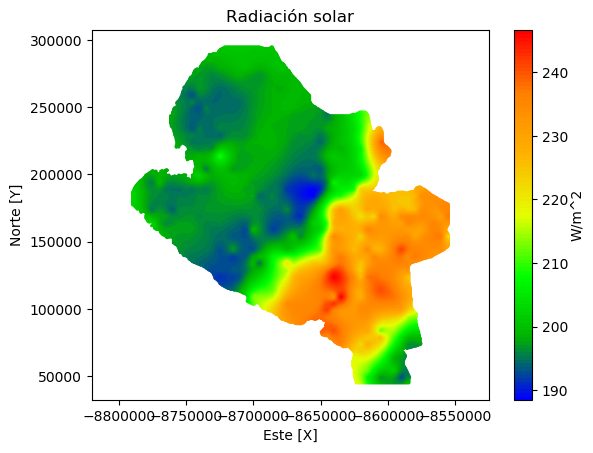

In [72]:
print(z.shape,x.shape)
mpl.style.use('default')
show_mapC(Xi,Yi,z)

In [30]:
kt.write_asc_grid(grid_x, grid_y, ss, filename="kriging_ordinario_var.asc") #Varianza de estimación en forma de matriz

In [160]:
asc = pd.read_csv("kriging_ordinario.asc", header=None, skiprows=7, sep="\s+") 
asc.shape

(450, 450)

In [161]:
cu2 = np.array(asc) #Conversión pandas dataframe a ndarray
cu2

array([[207.31, 207.31, 207.31, ..., 222.4 , 222.39, 222.38],
       [207.34, 207.33, 207.33, ..., 222.51, 222.5 , 222.49],
       [207.36, 207.36, 207.36, ..., 222.61, 222.61, 222.6 ],
       ...,
       [204.43, 204.41, 204.38, ..., 194.47, 194.44, 194.41],
       [204.49, 204.46, 204.44, ..., 194.41, 194.37, 194.34],
       [204.55, 204.52, 204.49, ..., 194.34, 194.31, 194.28]])

([], <a list of 0 Text yticklabel objects>)

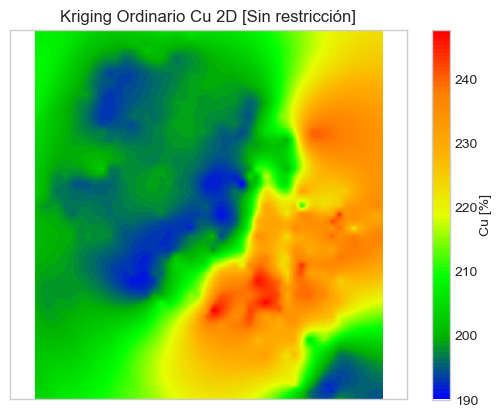

In [163]:
qwe5f  #fig = plt.figure(figsize=(17,15))

#plot1 = fig.add_subplot(131)
a = plt.imshow(cu2,extent=[x_min,x_max,y_min,y_max], cmap=cm, vmin=190) #gist_rainbow
plt.grid(False)

cbar = plt.colorbar()
cbar.set_label("Cu [%]", labelpad=+1)

plt.title('Kriging Ordinario Cu 2D [Sin restricción]')
marker_size = 1
#plt.scatter(x, y, marker_size, cu)
plt.axis('equal')
plt.xticks([])
plt.yticks([])